# Modifying the RI-algorithm to generate more diverse routes

### Stage 1: Undirected

<img src="multigraph_network.png" alt="Turn Categorization Based on Angle" />

# Step 1: Create Graph Representation

In [2]:
import networkx as nx
import math
import pandas as pd
import random
import osmnx as ox
import geopandas as gpd
import momepy
import matplotlib.pyplot as plt
import itertools
import numpy as np


c:\Users\Sneez\Desktop\Snowplowing\Snowplow-Routing-Code\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
edgelist = pd.read_csv("edges.csv")
nodelist = pd.read_csv("nodes.csv")

In [4]:
G = nx.MultiGraph()
for i,edges in edgelist.iterrows():
    G.add_edge(edges.iloc[0],edges.iloc[1],**edges.iloc[2:].to_dict())

for i,nodes in nodelist.iterrows():
    attributes = nodes[1:].to_dict()
    nx.set_node_attributes(G, {nodes['id']:  attributes})

In [5]:
print('# of edges: {}'.format(G.number_of_edges()))
print('# of nodes: {}'.format(G.number_of_nodes()))

print(G.edges(data=True))
print(G.nodes(data=True))

print(G)

# of edges: 7
# of nodes: 5
[(0, 2, {'distance': 1, 'priority': 1, 'time': 2, 'passes_rem': 1, 'salt_per': 1}), (2, 1, {'distance': 1, 'priority': 3, 'time': 1, 'passes_rem': 2, 'salt_per': 1}), (2, 1, {'distance': 1, 'priority': 1, 'time': 2, 'passes_rem': 1, 'salt_per': 1}), (2, 3, {'distance': 1, 'priority': 3, 'time': 1, 'passes_rem': 2, 'salt_per': 1}), (2, 3, {'distance': 1, 'priority': 1, 'time': 2, 'passes_rem': 1, 'salt_per': 1}), (1, 4, {'distance': 2, 'priority': 2, 'time': 2, 'passes_rem': 1, 'salt_per': 1}), (3, 4, {'distance': 2, 'priority': 2, 'time': 2, 'passes_rem': 1, 'salt_per': 1})]
[(0, {'x': 0, 'y': 0}), (2, {'x': 1, 'y': 1}), (1, {'x': 0, 'y': 2}), (3, {'x': 2, 'y': 0}), (4, {'x': 2, 'y': 2})]
MultiGraph with 5 nodes and 7 edges


In [6]:
def plot_multigraph(G, pos, title="Graph"):
    names = {name: name for name in G.nodes}
    nx.draw_networkx_nodes(G, pos, node_color = 'lightgreen', node_size = 250, alpha = 1)
    nx.draw_networkx_labels(G,pos,names,font_size=12,font_color='b')
    ax = plt.gca()
    for e in G.edges:
        ax.annotate("",
                    xy=pos[e[1]], xycoords='data',
                    xytext=pos[e[0]], textcoords='data',
                    arrowprops=dict(arrowstyle="-", color="0",
                                    shrinkA=10, shrinkB=10,
                                    patchA=None, patchB=None,
                                    connectionstyle="arc3,rad=rrr".replace('rrr',str(0.3*e[2])
                                    ),
                                    ),
                    )
    plt.title(title)
    plt.axis('off')
    plt.show()


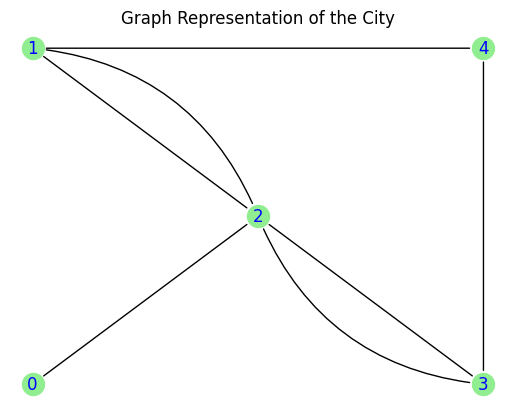

In [7]:

##### Visualize the Graph
# Define node positions data structure (dict) for plotting
node_positions = {node[0]: (node[1]['x'], node[1]['y']) for node in G.nodes(data=True)}
plot_multigraph(G, node_positions, "Graph Representation of the City")

# Step 2: Graph Configuration and Preprocessing

## Defining a Class for the Routes

We want to keep track of certain attributes of each traversed edge for backtracking purposes. Let's create a class to manage all the variables

In [8]:
class RouteStep:
    """
    Represents a step in a route.

    Attributes:
        node1 (str): The starting node of the step.
        node2 (str): The ending node of the step.
        id (int): The id of the step (identifier for parallel edges)
        wasDeadheaded (bool): Indicates whether the step was a deadhead (empty) move.
        hadOptions (bool): Indicates whether the step had multiple options for routing. Could have gone a different direction
        saltval (int): Indicates the amount of salt the vehicle had before traversing the arc. Useful for checking validity of solution
    """
    def __init__(self, node1="", node2="", id=0, wasDeadheaded=False, hadOptions=False, saltval = 0):
        self.node1 = node1
        self.node2 = node2
        self.id = id
        self.wasDeadheaded = wasDeadheaded
        self.hadOptions = hadOptions
        self.saltval = saltval

    def __str__(self):
        return f"{self.node1} --> {self.node2}. ({self.id}) Deadhead: {self.wasDeadheaded}. Had options: {self.hadOptions}. Salt value: {self.saltval}"

    def __repr__(self):
        return str(self)


## Identifying Turn Directions at an Intersection - **No Modifications Required**

Methodology: Use coordinate system. Identify the three coordinates of the triangle (can be degenerate) that every turn makes. Potential for linear algebra: dot product of the two vectors, or change of basis?

Example: going from (2,1) to (0,1) to (-1,-1)

v = [-2, 0]
w = [-1, -2]

Create a function that computes the signed angle between any two vectors

In [9]:
from math import atan2
from math import pi
def angle(v, w):
    '''
    Computes the signed angle (in degrees) between two vectors v and w
    '''
    dot = v[0]*w[0] + v[1]*w[1]     # Dot product between [x1, y1] and [x2, y2]
    det = v[0]*w[1] - v[1]*w[0]      # Determinant
    angle = atan2(det, dot)  # atan2(y, x) or atan2(sin, cos)

    return angle*180/pi

v=(1,0)
w=(0,-1)

angle(v,w)


-90.0

Using the angle, identify whether the turn is straight, left, right, or backwards.

In [10]:
def turn_direction(angle):
    '''
    Returns the direction of a turn given an angle
    '''
    if angle < 15 and angle > -15:
        return "straight"
    elif angle >= -90 and angle <= -15:
        return "right"
    elif angle <= 90 and angle >= 15:
        return "left"
    elif angle <= 135 and angle > 90:
        return "sharp left"
    elif angle >= -135 and angle < -90:
        return "sharp right"
    else:
        return "u-turn"


71.56505117707799 left


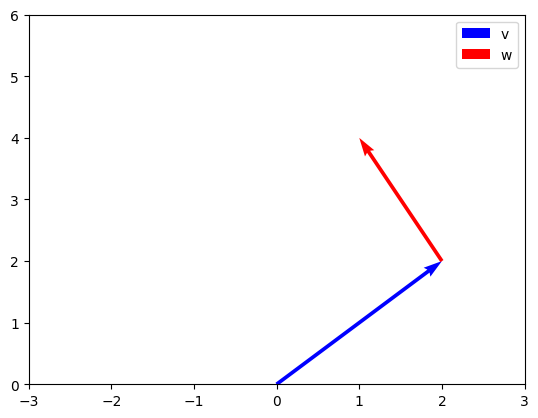

In [11]:
v=(2,2)
w=(-1,2)
theta = angle(v,w)
print(theta, turn_direction(theta))

# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the vectors
ax.quiver(0, 0, v[0], v[1], angles='xy', scale_units='xy', scale=1, color='blue', label='v')
ax.quiver(v[0], v[1], w[0], w[1], angles='xy', scale_units='xy', scale=1, color='red', label='w')

# Set the x and y limits
ax.set_xlim([-3, 3])
ax.set_ylim([0, 6])

# Add a legend
ax.legend()

# Show the plot
plt.show()

### Adding useful graph attributes - **No Modifications Needed**

Update the effective degree of all nodes. If $v$ is the vertice and $E_v$ is the set of all edges leaving from $v$, then the effective degree is 
$$\text{Deg(v)} = \sum_{e \in E_v} e(\text{passes})$$

Also, calculate the weighted degree of each node, defined as
$$\text{WeightedDeg(v)} = \sum_{e \in E_v} e(\text{passes})\cdot e(\text{priority})$$

Also, update the total amount of salting required for the road given the number of passes

In [44]:
def config_graph_attributes(G):
    for node in G.nodes:
        weight_deg = 0
        for edge in G.edges([node], data=True):
            weight_deg += edge[2]['passes_rem']*edge[2]['priority']
        G.nodes[node]['weighted_degree'] = weight_deg
    # add a new attribute to each edge, called "deadheading_passes" and initially set to 0
    for edge in G.edges(data=True):
        edge[2]['deadheading_passes'] = 0


config_graph_attributes(G)
# print result
for node in G.nodes(data=True):
    print(node)

(0, {'x': 0, 'y': 0, 'weighted_degree': 1})
(2, {'x': 1, 'y': 1, 'weighted_degree': 15})
(1, {'x': 0, 'y': 2, 'weighted_degree': 9})
(3, {'x': 2, 'y': 0, 'weighted_degree': 9})
(4, {'x': 2, 'y': 2, 'weighted_degree': 4})


# Step 3: Create a Dual Representation of the Graph

This is crucial to include turn directions as weights in shortest-paths. For this graph, we should have 7 nodes and 30 edges

**NetworkX has a function for this:
https://networkx.org/documentation/stable/reference/generated/networkx.generators.line.line_graph.html

Create dual representation

In [13]:
def identify_cost(G_primal, G_dual, edge1_dual, edge2_dual):
    '''
    Identifies the cost of traversing from edge1 to edge2
    nodes of the format: 
    edge1_dual = (node1, node2, id)
    '''
    # cost is the sum of the weights of the two nodes in the graph (which correspond to edges in the oringal)
    cost = G_dual.nodes[edge1_dual]['weight'] + G_dual.nodes[edge2_dual]['weight']

    # add the turn penalty cost
    turn_penalty = {"straight": 0, "right": 1, "left": 2, "sharp right": 2, "sharp left": 3, "u-turn": 4}

    first_node = 0
    second_node = 0
    third_node = 0

    # identify which way the edges are being traversed. need to traverse node1->common->node2
    if edge1_dual[1] == edge2_dual[0]:
        # common node in the middle, traverse by going node1->common->node2
        first_node = edge1_dual[0]
        second_node = edge1_dual[1]
        third_node = edge2_dual[1]
    
    elif edge1_dual[0] == edge2_dual[1]:
        # common node at the start fo first edge and end of second edge
        first_node = edge1_dual[1]
        second_node = edge1_dual[0]
        third_node = edge2_dual[0]
    
    elif edge1_dual[0] == edge2_dual[0]:
        # common node the first node of both edges, traverse the first edge first
        first_node = edge1_dual[1]
        second_node = edge1_dual[0]
        third_node = edge2_dual[1]

    elif edge1_dual[1] == edge2_dual[1]:
        # common node the second node of both edges
        first_node = edge1_dual[0]
        second_node = edge1_dual[1]
        third_node = edge2_dual[0]
    

    v_x = G_primal.nodes[second_node]['x']-G_primal.nodes[first_node]['x']
    v_y = G_primal.nodes[second_node]['y']-G_primal.nodes[first_node]['y']

    w_x = G_primal.nodes[third_node]['x']-G_primal.nodes[second_node]['x']
    w_y = G_primal.nodes[third_node]['y']-G_primal.nodes[second_node]['y']

    v = (v_x, v_y)
    w = (w_x, w_y)

    theta = angle(v,w)
    cost += turn_penalty[turn_direction(theta)]

    return cost

Testing multigraph functions

In [14]:
G_dual = nx.DiGraph(name="pseudo-dual")

# Create nodes in G_dual for each edge in G
for e in G.edges(data=True):
    node1 = e[0] 
    node2 = e[1]
    for k,v in dict(G[node1][node2]).items():
        # id, node1, node2
        G_dual.add_node((node1, node2, k), weight=v['distance'])

for node in G_dual.nodes(data=True):
    print(node)

for edges in G.edges(keys=True):
    print(edges)


((0, 2, 0), {'weight': 1})
((2, 1, 0), {'weight': 1})
((2, 1, 1), {'weight': 1})
((2, 3, 0), {'weight': 1})
((2, 3, 1), {'weight': 1})
((1, 4, 0), {'weight': 2})
((3, 4, 0), {'weight': 2})
(0, 2, 0)
(2, 1, 0)
(2, 1, 1)
(2, 3, 0)
(2, 3, 1)
(1, 4, 0)
(3, 4, 0)


In [15]:
def create_multi_dual(G: nx.MultiGraph):
    G_dual = nx.DiGraph(name="pseudo-dual")

    # Create nodes in G_dual for each edge in G
    for e in G.edges(data=True):
        node1 = e[0] 
        node2 = e[1]
        for k,v in dict(G[node1][node2]).items():
            #node1, node2, id
            G_dual.add_node((node1, node2, k), weight=v['time'])
    
    # Create edges in G_dual to represent connections between two edges in G
    edges_set = set()
    for edge1 in G.edges(keys=True):
        for edge2 in G.edges(keys=True):
            if edge1 != edge2:
                # if they share a common node (or both common nodes in the case of parallel edges)
                if edge1[1] == edge2[0] or edge1[0] == edge2[0] or edge1[1] == edge2[1]:
                    # get the weights for traversing in both directions
                    weight1 = identify_cost(G, G_dual, edge1, edge2)
                    weight2 = identify_cost(G, G_dual, edge2, edge1)

                    # add edges to graph
                    G_dual.add_edge(edge1, edge2, weight=weight1)
                    G_dual.add_edge(edge2, edge1, weight=weight2)

                    edges_set.add((edge1, edge2, weight1))
                    edges_set.add((edge2, edge1, weight2))
    
    # add source and target nodes
    for node in G:
        G_dual.add_node(str(node) + "_source", weight=0)
    # add edges connecting source and targets to valid gateways
    for node in G_dual.nodes():
        # skip the source nodes which are strings. The other nodes are tuples
        if (type(node) == str):
            continue
        G_dual.add_edge(str(node[0]) + "_source", node, weight=0)
        G_dual.add_edge(str(node[1]) + "_source", node, weight=0)

        G_dual.add_edge(node, str(node[0]) + "_source", weight=0)
        G_dual.add_edge(node, str(node[1]) + "_source", weight=0)
    
    return G_dual


def print_graph_attributes(G):
    for node in G.nodes(data=True):
        print(node)

    for edge in G.edges(data=True):
        print(edge)

In [16]:
G_dual = create_multi_dual(G)
print_graph_attributes(G_dual)

((0, 2, 0), {'weight': 2})
((2, 1, 0), {'weight': 1})
((2, 1, 1), {'weight': 2})
((2, 3, 0), {'weight': 1})
((2, 3, 1), {'weight': 2})
((1, 4, 0), {'weight': 2})
((3, 4, 0), {'weight': 2})
('0_source', {'weight': 0})
('2_source', {'weight': 0})
('1_source', {'weight': 0})
('3_source', {'weight': 0})
('4_source', {'weight': 0})
((0, 2, 0), (2, 1, 0), {'weight': 5})
((0, 2, 0), (2, 1, 1), {'weight': 6})
((0, 2, 0), (2, 3, 0), {'weight': 4})
((0, 2, 0), (2, 3, 1), {'weight': 5})
((0, 2, 0), '0_source', {'weight': 0})
((0, 2, 0), '2_source', {'weight': 0})
((2, 1, 0), (0, 2, 0), {'weight': 4})
((2, 1, 0), (2, 1, 1), {'weight': 7})
((2, 1, 0), (2, 3, 0), {'weight': 2})
((2, 1, 0), (2, 3, 1), {'weight': 3})
((2, 1, 0), (1, 4, 0), {'weight': 5})
((2, 1, 0), '2_source', {'weight': 0})
((2, 1, 0), '1_source', {'weight': 0})
((2, 1, 1), (0, 2, 0), {'weight': 5})
((2, 1, 1), (2, 1, 0), {'weight': 7})
((2, 1, 1), (2, 3, 0), {'weight': 3})
((2, 1, 1), (2, 3, 1), {'weight': 4})
((2, 1, 1), (1, 4, 0)

# Step 4: Route Construction Algorithm (RCA)

Variables:
| Variable | Definition 
|:--------:|:--------:|
|  RCL |  Restricted Candidate List |
|  $\alpha$   |  Threshold parameter. Value between 0 and 1  
|  C<sub>min   | Lowest incremental cost of a candidate element to be added to the partial solution    |
| C<sub>max | Highest incremental cost of a candidate element to be added to the partial solution|
| S_i | Amount of salt required to service road i |
|E| List of possible candidates that can be added to the partial solution
|No_Routes|Number of routes developed in the network



Overview:
1. If there is at least one required arc from the current node, then create a restricted candidate list based on the neighbors of the current node. Otherwise go to step 3
2. If RCL is empty, go to step 3. Otherwise choose a random arc from the RCL based on the threshold parameter and cost range
3. Go through the list of all required arcs and find the closest one.
4. Service that arc, subtracting one from the effective degree of the current node
5. Update the current node to the new node

Calculate shortest distance between each pair of nodes in the network using
Floyd's algorithm and visualize distance matrix

Define a cost function for traversing an arc

In [17]:
def cost(G, prev, curr, nxt, k):
    '''
    Returns the cost of traversing an edge between two nodes. Based on distance and turn direction
    '''
    cost = G[curr][nxt][k]['distance']

    # without previous node, we can't factor turn direction
    if prev is None:
        return cost
    
    # with a previous node, we incorporate turning penalites
    turn_cost = {"straight": 0, "right": 1, "left": 2, "sharp right": 2, "sharp left": 3, "u-turn": 4}

    v_x = G.nodes[curr]['x']-G.nodes[prev]['x']
    v_y = G.nodes[curr]['y']-G.nodes[prev]['y']

    w_x = G.nodes[nxt]['x']-G.nodes[curr]['x']
    w_y = G.nodes[nxt]['y']-G.nodes[curr]['y']

    v = (v_x, v_y)
    w = (w_x, w_y)

    theta = angle(v,w)
    cost += turn_cost[turn_direction(theta)]

    return cost

In [18]:
def needs_servicing(G, node1, node2, id):
    '''
    Returns whether or not the edge between two nodes requires servicing
    '''
    return G[node1][node2][id]['passes_rem'] > 0

### Start finding a route

Check if there are any required arcs remaining departing from the current node

In [19]:
def visit_arc(G: nx.Graph, curr: str, arc: tuple, route: list, options: bool, undirected=True):
    global curr_salt
    '''
    Visits an arc and updates the route and cost. Returns the new node that the arc is on
    
    Parameters:
        G (networkx.Graph): The graph representing the network
        curr (str): the current node
        arc (tuple): The arc to be visited
        route (list): The partial route taken so far (default: partial_route)
        undirected (bool): Flag indicating if the graph is undirected (default: True)
    
    Returns:
        str: The new node that the arc is on
    '''

    # identify the direction of traversal
    from_node = arc[0] if arc[0] == curr else arc[1]
    to_node = arc[0] if arc[0] != curr else arc[1]
    id = arc[2]
    
    # initialize routstep object
    route_step = RouteStep(from_node, to_node, id, hadOptions=options, saltval=curr_salt)

    # not deadheading. So we service the arc and update the effective degree of the relevant node
    # need a check to see if we can actually service the arc given the amount of salt we have left.
    salt_required = G[from_node][to_node][id]['salt_per']

    # needs servicing and we can service it. Update weighted and effective degree
    if needs_servicing(G, from_node, to_node, id) and curr_salt >= salt_required:
        G.nodes[from_node]['weighted_degree'] -= G[from_node][to_node][id]['priority']

        if (undirected):
            G.nodes[to_node]['weighted_degree'] -= G[from_node][to_node][id]['priority']

        curr_salt -= salt_required

        G[from_node][to_node][id]['passes_rem'] -= 1 # mark that we traversed this arc
        route_step.wasDeadheaded = False
    else:
        G[from_node][to_node][id]['deadheading_passes'] += 1
        route_step.wasDeadheaded = True

    route.append(route_step)
    return to_node

In [20]:
for edge in G.edges([1], data=True, keys=True):
    print(edge)

(1, 2, 0, {'distance': 1, 'priority': 3, 'time': 1, 'passes_rem': 2, 'salt_per': 1, 'deadheading_passes': 0})
(1, 2, 1, {'distance': 1, 'priority': 1, 'time': 2, 'passes_rem': 1, 'salt_per': 1, 'deadheading_passes': 0})
(1, 4, 0, {'distance': 2, 'priority': 2, 'time': 2, 'passes_rem': 1, 'salt_per': 1, 'deadheading_passes': 0})


In [21]:
def process_node(G, prev, curr):
    '''
    Returns a list of required arcs that depart from curr_node, as well as the minimum and maximum cost
    of all departing arcs
    '''
    c_min = math.inf
    c_max = -math.inf

    required = []
    for edge in G.edges([curr], data=True, keys=True):
        nxt = edge[1]
        k = edge[2] # identifier for parallel edges
        if edge[3]["passes_rem"] > 0:
            required.append(edge)
            c_min = min(cost(G, prev, curr, nxt, k), c_min)
            c_max = max(cost(G, prev, curr, nxt, k), c_max)
    return required, c_min, c_max

Since G_dual is never a multigraph, shortest paths shouldn't actually require modifying.

In [22]:
def move_between_nodes(G, G_dual, node1, node2, route_up_to_now, options=False):
    '''
    Moves between two nodes via the shortest path, updating any required arcs along the way. 

    '''
    node_path = nx.dijkstra_path(G_dual, str(node1)+"_source", str(node2)+"_source", weight="weight")
    
    # remember, nodes in the dualgraph are edges in the primal graph
    edges = [node for node in node_path if type(node) != str] # ignore source nodes

    curr = node1
    for edge in edges:
        curr = visit_arc(G, curr, edge, route=route_up_to_now, options=options)

In [23]:
def has_edge_within_capacity(G, node):
    global curr_salt
    if curr_salt == 0:
        return False
    for neighbor_edge in G.edges(node, data=True, keys=True):
        if neighbor_edge[3]['salt_per'] <= curr_salt and neighbor_edge[3]['passes_rem'] > 0:
            return True
    return False

def find_nearest_required(G, G_dual, node):
    '''
    Finds the path to the nearest node with a required arc to traverse.
    '''
    dists = dict()
    for target in G.nodes():
        distance = nx.dijkstra_path_length(G_dual, str(node) + "_source", str(target) + "_source", weight="weight")
        dists[target] = distance
    # loop through the dists array and find the nearest required arc
    min_dist = math.inf
    min_dist_node = None
    for target in G.nodes():
        if target == node:
            continue
        if G.nodes[target]['weighted_degree'] > 0 and dists[target] < min_dist:
            # check that the node has an edge to service within salt capacity
            if has_edge_within_capacity(G, target):
                min_dist = dists[target]
                min_dist_node = target
    
    if min_dist_node is None:
        return None
    # reconstruct path
    node_path = nx.dijkstra_path(G_dual, str(node)+"_source", str(min_dist_node)+"_source", weight="weight")
    edges = [edge for edge in node_path if type(edge) == tuple] # ignore source nodes
    return edges
        

Add an arc to the RCL if it has a cost in the range 
$$R = [C_{min}, C_{min} + \alpha \cdot (C_{max}-C_{min})]$$

Determine C<sub>min</sub> and C<sub>max</sub> by looping through first.

A value of alpha close to zero means that we will almost always choose the least cost arc (think greedy), while value close to one means the choice will be virtually random. Alpha=zero is nearest neighbor heuristic

To choose an arc from the RCL, we either randomly choose or weight based on turn direction and degree of the next intersection.

Parameter: Weights is the amount of weight assigned to turning, degree, and priority. Total weight is 

$$(\text{weights[0]}) \cdot \text{turns} + (\text{weights[1]})\cdot \text{degree} + (\text{weights[2]})\cdot \text{priority}$$

Continue running the route construction algorithm until there are no required nodes in the graph left. Run the algorithm on a copy of G so that the original graph is preserved

In [24]:
def chooseArc(G, rcl, prev_node, weights):
    """
    Selects an arc from a Restricted Candidate List (RCL) based on various weights.

    Parameters:
    - G: The graph representing the road network.
    - rcl: The Restricted Candidate List (RCL) containing the arcs to choose from.
    - prev_node: The previous node in the path.
    - weights: A list of weights used to calculate the arc selection probabilities. The first weight is for turn direction, the second weight is for the degree of the next node, and the third weight is for the priority of the arc.
    Precondition: sum of weights is 1.

    Returns:
    - The selected arc from the RCL.

    Algorithm:
    1. If the previous node is None or a random number is greater than 0.8, choose an arc randomly from the RCL.
    2. Calculate weights for each arc in the RCL based on turn direction, degree of the next node, and priority.
    3. Normalize the sum of the weights.
    4. Choose an arc based on the weights, where higher weights are more likely to be chosen.

    Note:
    - The angle, turn_direction, and angle functions are assumed to be defined elsewhere.

    """

    # randomize 20% of the time
    if (random.random() > .8):
        return random.choice(rcl)
    
    turn_weights = {"straight": 6, "right": 5, "left": 4, "sharp right": 3, "sharp left": 2, "u-turn": 1}
    weights_turns = np.empty(len(rcl))
    weights_degrees = np.empty(len(rcl))
    weights_priority = np.empty(len(rcl))

    # calculate weights by turn direction, degree of next node, and priority
    i = 0
    for edge in rcl:
        curr_node = edge[0]
        next_node = edge[1]
        k = edge[2]
        # only calculate turn direction if there is a previous node
        if prev_node is not None:
            v_x = G.nodes[curr_node]['x']-G.nodes[prev_node]['x']
            v_y = G.nodes[curr_node]['y']-G.nodes[prev_node]['y']

            w_x = G.nodes[next_node]['x']-G.nodes[curr_node]['x']
            w_y = G.nodes[next_node]['y']-G.nodes[curr_node]['y']

            v = (v_x, v_y)
            w = (w_x, w_y)

            theta = angle(v,w)

            weights_turns[i] = (turn_weights[turn_direction(theta)])
        weights_degrees[i] = G.nodes[next_node]['weighted_degree']
        weights_priority[i] = G[curr_node][next_node][k]['priority']
        i+=1


    # normalize the sum of the weights
    weights_degrees = weights_degrees / np.sum(weights_degrees)
    weights_priority = weights_priority / np.sum(weights_priority)

    if prev_node is not None:
        weights_turns = weights_turns / np.sum(weights_turns)
        weights_tot = weights[0]*weights_turns + weights[1]*weights_degrees + weights[2]*weights_priority
    # if there is no previous node, we are at depot, so turn direction doesn't matter.
    else:
        weights_tot = weights[1]*weights_degrees + weights[2]*weights_priority
        weights_tot = weights_tot / np.sum(weights_tot)
    
    # choose an arc based on the weights (higher weights are more likely to be chosen)
    index = int(np.random.choice(np.linspace(0,len(rcl)-1,len(rcl)), p=weights_tot))
    # print("Weights", weights_tot, "prev node is none?", prev_node is None)
    # print("choice: ", rcl[index][0], rcl[index][1])
    # print("RCl was ", [(edge[0], edge[1]) for edge in rcl])
    return rcl[index]


In [25]:
def RCA(G, G_dual, curr_node, alpha, arc_selection_weights, route: list[RouteStep]):
    global curr_salt
    while True:
        prev_node = route[-1].node1 if len(route) > 0 else None
        
        required_arcs, c_min, c_max = process_node(G, prev_node, curr_node)
        rcl = [] # initialize restricted candidate list
        
        for edge in required_arcs:            
            if cost(G, prev_node, edge[0], edge[1], edge[2]) >= c_min and cost(G, prev_node, edge[0], edge[1], edge[2]) <= c_min + alpha*(c_max-c_min) and G[edge[0]][edge[1]][edge[2]]['salt_per'] <= curr_salt:
                rcl.append(edge)
        
        # chooes an arc based on restricted candidate list if not empty
        if len(rcl) > 0:
            multiple_neighbors = len(G.edges(curr_node)) > 1
            chosen_arc = chooseArc(G, rcl, prev_node, arc_selection_weights)
            curr_node = visit_arc(G, curr_node, chosen_arc, options=multiple_neighbors, route=route)

        # if restricted candidate list is empty, follow path to nearest node with required arc
        else:
            path = find_nearest_required(G, G_dual, curr_node)
            # no more required arcs in the graph that we can service, so we're done.
            # return to the depot and refill salt cap
            if path is None:
                move_between_nodes(G, G_dual, curr_node, 0, route, options=False) # no other options to traverse
                return route
            
            # otherwise go to the arc to visit
            for edge in path:
                multiple_neighbors = len(G.edges(curr_node)) > 1 # could we take a different path
                curr_node = visit_arc(G, curr_node, edge, options=multiple_neighbors, route=route)
                if curr_node == 0:
                    return route
        # if we're at the depot for any reason, that's the end of a route.
        if curr_node == 0:
            return route

In [26]:
print(G.edges(2))

[(2, 0), (2, 1), (2, 1), (2, 3), (2, 3)]


In [27]:
def all_serviced(G):
    for node in G.nodes():
        if G.nodes[node]['weighted_degree'] > 0:
            return False
    return True

Generate routes

In [28]:
# define initial conditions
SALT_CAP = 5

curr_node = 0 # set starting node to depot
alpha = 1 # set alpha parameter
selection_weights = [0.4, 0.2, 0.4] # set weights for arc selection
G_copy = G.copy()
G_dual = create_multi_dual(G_copy)
curr_salt = SALT_CAP
routes = []
partial_route: list[RouteStep] = list()
number_of_routes = 0

while all_serviced(G_copy) == False:
    partial_route = RCA(G_copy, G_dual, curr_node, alpha, selection_weights, partial_route)
    routes.append(partial_route)
    curr_salt = SALT_CAP
    curr_node = 0
    partial_route = list()
    number_of_routes += 1

print("Number of routes:" + str(len(routes)))
for route in routes:
    for edge in route:
        print(edge)
    
    print("*****\n")

Number of routes:2
0 --> 2. (0) Deadhead: False. Had options: False. Salt value: 5
2 --> 1. (0) Deadhead: False. Had options: True. Salt value: 4
1 --> 2. (1) Deadhead: False. Had options: True. Salt value: 3
2 --> 1. (0) Deadhead: False. Had options: True. Salt value: 2
1 --> 4. (0) Deadhead: False. Had options: True. Salt value: 1
4 --> 1. (0) Deadhead: True. Had options: False. Salt value: 0
1 --> 2. (0) Deadhead: True. Had options: False. Salt value: 0
2 --> 0. (0) Deadhead: True. Had options: False. Salt value: 0
*****

0 --> 2. (0) Deadhead: True. Had options: False. Salt value: 5
2 --> 3. (0) Deadhead: False. Had options: True. Salt value: 5
3 --> 2. (0) Deadhead: False. Had options: True. Salt value: 4
2 --> 3. (1) Deadhead: False. Had options: True. Salt value: 3
3 --> 4. (0) Deadhead: False. Had options: True. Salt value: 2
4 --> 1. (0) Deadhead: True. Had options: False. Salt value: 1
1 --> 2. (0) Deadhead: True. Had options: False. Salt value: 1
2 --> 0. (0) Deadhead: True.

Plotting is a convoluted challenge that I won't worry about

(0, 2, 0)
(2, 1, 0)
(2, 1, 1)
(2, 3, 0)
(2, 3, 1)
(1, 4, 0)
(3, 4, 0)
(0, 2, {'distance': 1, 'priority': 1, 'time': 2, 'passes_rem': 1, 'salt_per': 1, 'deadheading_passes': 0})
(2, 1, {'distance': 1, 'priority': 3, 'time': 1, 'passes_rem': 2, 'salt_per': 1, 'deadheading_passes': 0})
(2, 1, {'distance': 1, 'priority': 1, 'time': 2, 'passes_rem': 1, 'salt_per': 1, 'deadheading_passes': 0})
(2, 3, {'distance': 1, 'priority': 3, 'time': 1, 'passes_rem': 2, 'salt_per': 1, 'deadheading_passes': 0})
(2, 3, {'distance': 1, 'priority': 1, 'time': 2, 'passes_rem': 1, 'salt_per': 1, 'deadheading_passes': 0})
(1, 4, {'distance': 2, 'priority': 2, 'time': 2, 'passes_rem': 1, 'salt_per': 1, 'deadheading_passes': 0})
(3, 4, {'distance': 2, 'priority': 2, 'time': 2, 'passes_rem': 1, 'salt_per': 1, 'deadheading_passes': 0})


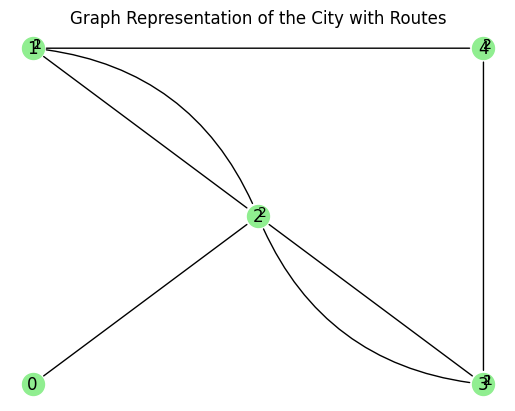

In [29]:
def plot_multigraph_routes(G, pos, routes, title="Graph"):
    names = {name: name for name in G.nodes}
    nx.draw_networkx_nodes(G, pos, node_color = 'lightgreen', node_size = 250, alpha = 1)
    nx.draw_networkx_labels(G,pos,names,font_size=12,font_color='black')
    ax = plt.gca()
    for e in G.edges:
        print(e)
        ax.annotate("",
                    xy=pos[e[1]], xycoords='data',
                    xytext=pos[e[0]], textcoords='data',
                    arrowprops=dict(arrowstyle="-", color="0",
                                    shrinkA=10, shrinkB=10,
                                    patchA=None, patchB=None,
                                    connectionstyle="arc3,rad=rrr".replace('rrr',str(0.3*e[2])
                                    ),
                                    ),
                    )
    for e in G.edges(data=True):
        print(e)
        txt = e[2]['time']
        ax.annotate(txt, xy=pos[e[1]])


    plt.title(title)
    plt.axis('off')
    plt.show()

plot_multigraph_routes(G, node_positions, routes, "Graph Representation of the City with Routes")


## Evaluating Tour Cost

Considerations: Priority. Number of deadheaded routes. Number of returns required to depot (total number of routes). Number of left turns. 

In [30]:
def turn_penalty(edge1, edge2):
    penalties = {"straight": 0, "right": 1, "left": 2, "sharp right": 2, "sharp left": 3, "u-turn": 4}
    node1 = edge1[0]
    node2 = edge1[1]
    node3 = edge2[1]

    v_x = G.nodes[node2]['x']-G.nodes[node1]['x']
    v_y = G.nodes[node2]['y']-G.nodes[node1]['y']

    w_x = G.nodes[node3]['x']-G.nodes[node2]['x']
    w_y = G.nodes[node3]['y']-G.nodes[node2]['y']

    v = (v_x, v_y)
    w = (w_x, w_y)

    theta = angle(v,w)
    return penalties[turn_direction(theta)]

In [31]:
def routes_cost_updated(routes, TURN_PENALTY_FACTOR, NUMROUTES_PENALTY, DEADHEAD_PENALTY):
    cost = 0
    time = 0
    for route in routes:
        for i in range(len(route)):
            routeStep1 = route[i]
            edge = (routeStep1.node1, routeStep1.node2)
            edge_id = routeStep1.id

            # penalize the turn
            if i+1 < len(route):
                next_edge = (route[i+1].node1, route[i+1].node2)
                cost += TURN_PENALTY_FACTOR*turn_penalty(edge, next_edge)

            # penalize priority and distance
            edge_data = G[edge[0]][edge[1]][edge_id]
            
            time += edge_data['time']
            priority_cost = edge_data['priority'] * time
            
            cost += edge_data['distance']+priority_cost
        # penalize number of returns to depot
        cost += NUMROUTES_PENALTY

    # penalize deadheading
    for edge in G.edges(data=True):
        cost += edge[2]['deadheading_passes']*DEADHEAD_PENALTY
    return cost

routes_cost_updated(routes, 10, 1, 1)


837

## Step 3: Generate Neighborhood Routes - New approach: Backtracking Decision Tree

Approach: take an existing route as a parameter. Backtrack and make a different choice for an arc to select to get a similar but different route. Evaluate with cost function

Create a hyperparameter $0 \le \beta \le 100$ such that $\beta$% of the time will backtrack to RCL modification, whereas the other $(1-\beta)$% of the time we will backtrack at any node with a neighbor (as long as the salt isn't zero, meaning the truck is headed towards the depot)

First, we create a function to undo the moves of the previous route

In [32]:
def unvisit_arc(G, route_step: RouteStep, undirected=True):
    global curr_salt
    node1 = route_step.node1
    node2 = route_step.node2
    edge_id = route_step.id

    # if we deadheaded, undo the count
    if route_step.wasDeadheaded:
        G[node1][node2][edge_id]["deadheading_passes"] -= 1

    # didn't deadhead, undo everything else
    else:
        G.nodes[node1]['weighted_degree'] += G[node1][node2][edge_id]['priority']
        if (undirected):
            G.nodes[node2]['weighted_degree'] += G[node1][node2][edge_id]['priority']

        G[node1][node2][edge_id]['passes_rem'] += 1
    
    curr_salt = route_step.saltval

    return node1

In [33]:
def finish_route(G, G_dual, curr_node, full_routes: list[list[RouteStep]], part_route: list[RouteStep]):
    global curr_salt
    # define initial conditions
    alpha = 1 # set alpha parameter
    selection_weights = [0.4, 0.2, 0.4] # set weights for arc selection
    routes = full_routes.copy()
    partial_route = part_route.copy()
    while all_serviced(G) == False:
        partial_route = RCA(G, G_dual, curr_node, alpha, selection_weights, partial_route)
        routes.append(partial_route)
        curr_salt = SALT_CAP
        curr_node = 0
        partial_route = list()

    return routes


What do the variables look like after the route generation?

In [34]:
def print_graph_attributes(G):
    for node in G.nodes(data=True):
        print(node)

    for edge in G.edges(data=True):
        print(edge)

Generate an alternative route. Now allows worse choices, branching earlier. O(n) for determining max_depth. Simulated annealing rather slow

In [35]:
def max_depth(routes):
    count = 0
    for route in routes:
        for edge in route:
            if edge.hadOptions == True:
                count += 1
    return count

In [36]:
# define initial conditions
curr_node = 0 # set starting node to depot
alpha = 1 # set alpha parameter
selection_weights = [0.4, 0.2, 0.4] # set weights for arc selection
G_copy = G.copy()
G_dual = create_multi_dual(G_copy)
curr_salt = SALT_CAP
routes = []
partial_route = list() # list of tuples
number_of_routes = 0
while all_serviced(G_copy) == False:
    partial_route = RCA(G_copy, G_dual, curr_node, alpha, selection_weights, partial_route)
    routes.append(partial_route)
    curr_salt = SALT_CAP
    curr_node = 0
    partial_route = list()
    number_of_routes += 1

print("Number of routes:" + str(len(routes)))
for route in routes:
    for edge in route:
        print(edge)
    
    print("*****\n")

def neighbor_route(G, G_dual, full_route: list[list[RouteStep]], target_layers=1):
    global curr_salt
    global selection_weights
    # flatten the routes so that all steps are in one massive list
    new_route = sum(full_route, [])

    route_step = new_route[-1]

    layers = 0
    while layers < target_layers:
        unvisit_arc(G, route_step)
        new_route.pop()
        route_step = new_route[-1]
        # made it one layer back
        if route_step.hadOptions == True:
            layers += 1
        
    # one more unvisit to get to the edge that had options
    unvisit_arc(G, route_step)
    new_route.pop()
    old_route_step = route_step # the next step in the original route (we don't want to choose this again)
    route_step = new_route[-1] # the step before the one we just unvisited (we are currently at route_step.node2)

    curr_node = route_step.node2
    prev_node = route_step.node1
    
    # once we get there, we have to choose a different path
    # look at the rcl at that point and choose a different node to go to
    required_arcs, c_min, c_max = process_node(G, prev_node, curr_node)
    rcl = [] # initialize restricted candidate list
    for edge in required_arcs:
        if cost(G, prev_node, edge[0], edge[1], edge[2]) >= c_min and cost(G, prev_node, edge[0], edge[1], edge[2]) <= c_min + alpha*(c_max-c_min) and G[edge[0]][edge[1]][edge[2]]['salt_per'] <= curr_salt:
            # extra check to make sure we don't go down the same path
            if not (edge[0] == old_route_step.node1 and edge[1] == old_route_step.node2 and edge[2] == old_route_step.id):
                rcl.append(edge)

    # choose a new arc based on restricted candidate list if it isn't empty
    if len(rcl) > 0:
        chosen_arc = chooseArc(G, rcl, prev_node, selection_weights)

    # by definition in RCA, hadOptions being true guarentees there is at least two edges leading off, so we can always find a new branch to take.
    else:
        edge_list = list(G.edges(curr_node, data=True, keys=True))
        edge = random.choice(edge_list)
        while edge[0] == old_route_step.node1 and edge[1] == old_route_step.node2 and edge[2] == old_route_step.id:
            edge = random.choice(edge_list)
        chosen_arc = edge

    # print("making new choice: curr node: ", curr_node, "chosen arc: ", chosen_arc, "\n Former chocie was ", old_route_step, "\nPrev routestep was ", route_step)
    curr_node = visit_arc(G, curr_node, chosen_arc, options=True, route=new_route)

    routes_2d_list = list()

    # recreate the 2d array of routes up to the point where we switch choices
    tot_sum = 0
    for i in range(len(full_route)):
        tot_sum += len(full_route[i])
        if tot_sum > len(new_route):
            tot_sum -= len(full_route[i])
            break
        routes_2d_list.append(full_route[i])
    
    new_part_route = new_route[tot_sum:]
    
    return finish_route(G, G_dual, curr_node, routes_2d_list, new_part_route)

# choose anywhere from one to max backtracking steps
l = max_depth(routes)
layers_backtracked = np.random.choice(np.linspace(1, l, l)) # need a safety check to not backtrack all the way
routes_neighbor = neighbor_route(G_copy, G_dual, routes, target_layers=layers_backtracked)


Number of routes:2
0 --> 2. (0) Deadhead: False. Had options: False. Salt value: 5
2 --> 3. (0) Deadhead: False. Had options: True. Salt value: 4
3 --> 4. (0) Deadhead: False. Had options: True. Salt value: 3
4 --> 1. (0) Deadhead: False. Had options: True. Salt value: 2
1 --> 2. (1) Deadhead: False. Had options: True. Salt value: 1
2 --> 0. (0) Deadhead: True. Had options: False. Salt value: 0
*****

0 --> 2. (0) Deadhead: True. Had options: False. Salt value: 5
2 --> 1. (0) Deadhead: False. Had options: True. Salt value: 5
1 --> 2. (0) Deadhead: False. Had options: True. Salt value: 4
2 --> 3. (0) Deadhead: False. Had options: True. Salt value: 3
3 --> 2. (1) Deadhead: False. Had options: True. Salt value: 2
2 --> 0. (0) Deadhead: True. Had options: False. Salt value: 1
*****



In [37]:
def print_route(routes):
    for route in routes:
        for edge in route:
            print(edge)
        
        print("*****\n")
print_route(routes_neighbor)
print(layers_backtracked)

0 --> 2. (0) Deadhead: False. Had options: False. Salt value: 5
2 --> 3. (0) Deadhead: False. Had options: True. Salt value: 4
3 --> 4. (0) Deadhead: False. Had options: True. Salt value: 3
4 --> 1. (0) Deadhead: False. Had options: True. Salt value: 2
1 --> 2. (1) Deadhead: False. Had options: True. Salt value: 1
2 --> 0. (0) Deadhead: True. Had options: False. Salt value: 0
*****

0 --> 2. (0) Deadhead: True. Had options: False. Salt value: 5
2 --> 1. (0) Deadhead: False. Had options: True. Salt value: 5
1 --> 2. (0) Deadhead: False. Had options: True. Salt value: 4
2 --> 3. (1) Deadhead: False. Had options: True. Salt value: 3
3 --> 2. (0) Deadhead: False. Had options: True. Salt value: 2
2 --> 0. (0) Deadhead: True. Had options: False. Salt value: 1
*****

2.0


Next step: plot side by side and compare

In [38]:
def plot_routes(G, routes, ax : plt.Axes):
    colors = ['blue', 'red', 'green', 'purple']
    nx.set_edge_attributes(G,"", "plot_sequence")
    nx.draw_networkx(G, pos=node_positions, node_size=10, node_color='black', with_labels=True, ax=ax)

    for color, route in enumerate(routes):
        visited = []
        for i, route_step in enumerate(route):
            edge = (route_step.node1, route_step.node2)
            # if we've visited the arc already on this route, add to plot_sequence. otherwise create new
            if((edge[0], edge[1]) not in visited and (edge[1], edge[0]) not in visited):
                new_plot_sequence = ""
                for j in range(len(G[edge[0]][edge[1]]["plot_sequence"])):
                    new_plot_sequence += "  "
                G[edge[0]][edge[1]]['plot_sequence'] = new_plot_sequence + ' ' + str(i+1)
            else:
                G[edge[0]][edge[1]]['plot_sequence'] += ' ' + str(i+1)
            visited.append(edge)
        for route_step in route:
            edge = (route_step.node1, route_step.node2)
            x = (node_positions[edge[0]][0] + node_positions[edge[1]][0]) / 2 - .3
            y = (node_positions[edge[0]][1] + node_positions[edge[1]][1]) / 2
            ax.text(x, y, G[edge[0]][edge[1]]["plot_sequence"], color=colors[color], fontsize=12, fontweight = 'bold')

In [39]:
print("Original cost:", routes_cost_updated(routes, 10, 1, 1))
print("Neighbor cost:", routes_cost_updated(routes_neighbor, 10, 1, 1))

Original cost: 477
Neighbor cost: 482


## Step 3: Generate Alternative Routes - Simulated Annealing Heuristic

Principle: Initially, at high temperature, solutions with worse costs are accepted with more likelihood than later at lower temperatures, where the algorithm attempts to converage on a minimum by primarily accepting improvements. See this [reference](https://www.baeldung.com/cs/simulated-annealing) for a good explanation

Variables:
| Variable | Definition 
|:--------:|:--------:|
|  T |  Temperature |
| T<sub> min| Lowest Temperature before algorithm terminates|
|  N   |  Counter (number of iterations at the current temperature)  
|  N<sub>max   | Max number of iterations at each temperature | 
| RCA_Cost | Cost obtained from the construction heuristic|
| RCA_Routes | Set of routes obtained from construction heuristic |
|Best_Cost| Lowest cost (of the best solution)|
|Best_Routes| Route corresponding to the lowest cost
|Curr_Cost| Current cost|
|Curr_Routes| Set of routes corresponding to current cost|
|R|Random value between 0 and 1|
|SA_Cost| Simulated Annealing Cost|
|SA_Routes| Simulated Annealing route set|
|$\Delta$ TC| Value of (Curr_Cost - SA_Cost)|
|a| Temperature reduction factor (hyperparameter)|
|N_iteration| Counter (number of iterations in the heuristic)|
|Max_Iteration| Maximum number of iterations in the heuristic|




In [40]:
def simulated_annealing(a, T, T_min, N_max, Max_iterations, Initial_Cost, Initial_Routes):
    Best_Cost = Initial_Cost
    Best_Routes = Initial_Routes

    Curr_Cost = Initial_Cost
    Curr_Routes = Initial_Routes

    N_iteration = 0
    while T > T_min and N_iteration < Max_iterations:
        N = 0
        # this part is ucrrently useless because neighor_route will always generate the same thing
        while N < N_max:
            # get neighbor
            depth = max_depth(Curr_Routes)
            SA_route = neighbor_route(G_copy, G_dual, Curr_Routes, target_layers=random.randint(1,depth))
            SA_cost = routes_cost_updated(SA_route, 10, 1, 1)
            delta = SA_cost - Curr_Cost
            R = random.random()
            
            if delta <= 0 or R < math.exp(-delta/T):
                Curr_Cost = SA_cost
                Curr_Routes = SA_route
                
                if Curr_Cost < Best_Cost:
                    Best_Cost = Curr_Cost
                    Best_Routes = Curr_Routes
            N += 1
        N_iteration += 1
        T = a*T
        print(T)
    return Best_Routes


Initial parameters chosen based on article.

T = CostDiff/ln(.35)
CostDiff = average of all costs of edges

In [41]:
# set hyperparameters
a = .75 # temperature reduction, between 0 and 1.

T = -sum(cost(G, None, edge[0], edge[1], edge[2]) for edge in G.edges(keys=True, data=True))/math.log(.35) # initial temperature
T_min = 0.0001 # minimum temperature
N_max = 300 # max number of iteraitons at each temperature
Max_Iterations = 100000 # max number of total iterations

RCA_Cost = routes_cost_updated(routes, 10, 1, 1)
RCA_Routes = routes

best_routes_final = simulated_annealing(a, T, T_min, N_max, Max_Iterations, RCA_Cost, RCA_Routes)

6.4296606467722635
4.822245485079198


3.6166841138093986
2.712513085357049
2.0343848140177867
1.52578861051334
1.144341457885005
0.8582560934137538
0.6436920700603153
0.48276905254523644
0.36207678940892735
0.2715575920566955
0.20366819404252162
0.15275114553189123
0.11456335914891842
0.08592251936168882
0.06444188952126662
0.04833141714094996
0.03624856285571247
0.027186422141784353
0.020389816606338266
0.0152923624547537
0.011469271841065276
0.008601953880798957
0.006451465410599218
0.004838599057949413
0.00362894929346206
0.002721711970096545
0.002041283977572409
0.0015309629831793067
0.00114822223738448
0.0008611666780383601
0.0006458750085287701
0.0004844062563965776
0.0003633046922974332
0.0002724785192230749
0.00020435888941730616
0.00015326916706297962
0.00011495187529723472
8.621390647292604e-05


In [42]:
print("Original cost:", RCA_Cost)
print("After simulated annealing", routes_cost_updated(best_routes_final, 10, 1, 1))

print_route(best_routes_final)

Original cost: 477
After simulated annealing 390
0 --> 2. (0) Deadhead: False. Had options: False. Salt value: 5
2 --> 3. (0) Deadhead: False. Had options: True. Salt value: 4
3 --> 2. (0) Deadhead: False. Had options: True. Salt value: 3
2 --> 1. (0) Deadhead: False. Had options: True. Salt value: 2
1 --> 2. (0) Deadhead: False. Had options: True. Salt value: 1
2 --> 0. (0) Deadhead: True. Had options: False. Salt value: 0
*****

0 --> 2. (0) Deadhead: True. Had options: False. Salt value: 5
2 --> 1. (1) Deadhead: False. Had options: True. Salt value: 5
1 --> 4. (0) Deadhead: False. Had options: True. Salt value: 4
4 --> 3. (0) Deadhead: False. Had options: True. Salt value: 3
3 --> 2. (1) Deadhead: False. Had options: True. Salt value: 2
2 --> 0. (0) Deadhead: True. Had options: False. Salt value: 1
*****



Plotting is screwed

KeyError: 'plot_sequence'

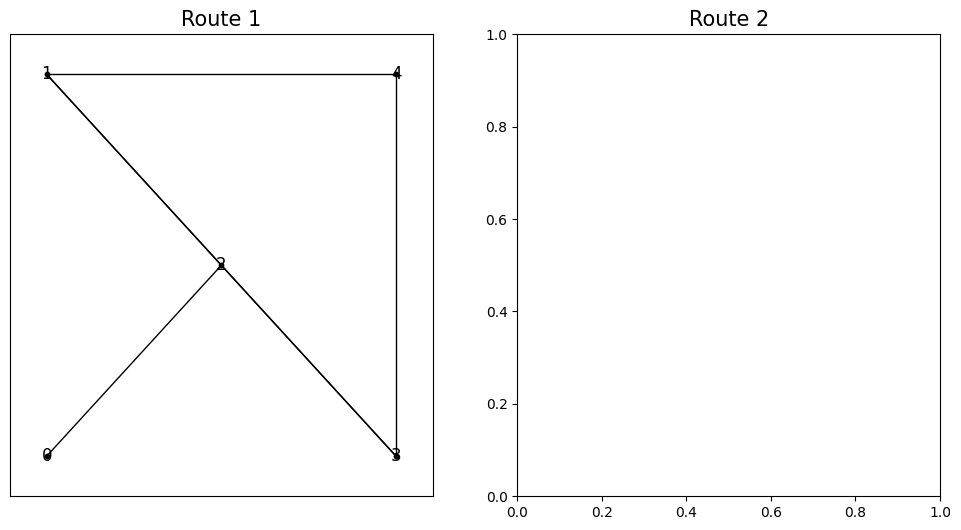

In [43]:
def plot_routes_compare(G, routes):
    route1 = routes[0]
    route2 = routes[1]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.set_title('Route 1', size=15)
    ax2.set_title('Route 2', size=15)
    plot_routes(G, route1, ax1)
    plot_routes(G, route2, ax2)
    plt.show()
        
plot_routes_compare(G_copy, [routes, routes_neighbor])
print("Cost comparision:")
